In [4]:
#numpy and pandas
import numpy as np
import random as r

#graphing imports
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns  # for nicer graphics

#jupyter-lab configs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import import_ipynb

#config imports
import warnings; warnings.simplefilter('ignore')

#models
from scipy import stats as st

## Gibbs Sampler

Recall that, mean given variance has the full conditional
$
P(\mu | \sigma^2,y_1,..,y_n) \propto N(\frac{\frac{n\bar{y}}{\sigma^2} + \frac{\mu_0}{\sigma^2_0}}{\frac{n/\sigma^2}{1/\sigma_0^2}},\frac{1}{\frac{n}{\sigma^2} + \frac{1}{\sigma^2_0}})
$

and the variance given mean has the full conditional

$
P(\sigma^2 | \mu,y_1,..,y_n) \propto IG(\nu_0 + \frac{n}{2}, \beta_0 + \frac{\Sigma_{i=1}^n(y_i - \mu)^2}{2}) 
$

In the functions, we are essentially implementing these formulas

In [5]:
def update_mu(n_samples, y_bar, sigma2, mu_0, sigma2_0):
    """function to update mu
        Parameters
        ----------
        n_samples : int
            number of samples of data that we are given
        y_bar : int
            mean of the data
        sigma2: int
            current accepted variance of the gibbs sampler
        mu_0: int
            hyper parameter of mean of the prior mean
        sigma2_0: int
            hyper parameter of variance of the prior mean
            
        Returns
        ----------
        sampled_mean: int
            new updated value of mean
    """
    new_sigma = 1/((n_samples/sigma2)+(1/sigma2_0))
    new_mean = new_sigma * ((n_samples * y_bar/sigma2) + (mu_0/sigma2_0))
    sampled_mean = np.random.normal(new_mean, np.sqrt(new_sigma))
    return sampled_mean

In [6]:
def update_sig2(n_samples, y, mu, nu_0, beta_0):
    """function to update mu
        Parameters
        ----------
        n_samples : int
            number of samples of data that we are given
        y : list[]
            data
        mu: int
            current accepted mean of the gibbs sampler
        nu_0: int
            hyper parameter of mean of the prior variance
        sigma2_0: int
            hyper parameter of variance of the prior variance
            
        Returns
        ----------
        sampled_variance: int
            new updated value of variance
    """
    new_alpha = nu_0 + n_samples / 2
    new_beta = beta_0 + (sum([(i-mu)**2 for i in y])/2)
    sampled_variance = 1 / np.random.gamma(new_alpha, 1/new_beta)

    return sampled_variance

In [7]:
def gibbs_sampler(y, num_iter, prior):
    """function to update mu
        Parameters
        ----------
        y : list[]
            data
        num_iter: int
            number of iterations of the gibbs sampler
        prior: dict
            dictionary containing hyper parameters of the mean and variance
            
        Returns
        ----------
        mu: int
            mean returned from the gibbs sampler
        sig2: int
            variance returned from the gibbs sampler
    """
    y_bar = np.mean(y)
    n_samples = len(y)
    
    #initialize empty lists for mu and sigmas
    mu = []
    sig2 = []
    
    #initializing mu so we can sample sigma
    mu_current = 0
    
    #sampling means and variances from the functions described above
    for i in range(num_iter):
        sig2_current = update_sig2(n_samples, y, mu_current, prior['nu_0'], prior['beta_0'])
        mu_current = update_mu(n_samples, y_bar, sig2_current, prior['mu_0'], prior['sig2_0'])
        
        sig2.append(sig2_current)
        mu.append(mu_current)
        
    return mu,sig2
        

In [8]:
r.seed(35)
y = list(np.random.normal(2,1,100))
y_bar = np.mean(y)

## prior
prior_gibbs = {}
prior_gibbs['mu_0'] = 0.0
prior_gibbs['sig2_0'] = 1.0
prior_gibbs['nu_0'] = 1 # prior alpha for inverse-gamma
prior_gibbs['beta_0'] = 1 # prior beta for inverse-gamma

gibbs_posterior = gibbs_sampler(y, 1000, prior_gibbs)

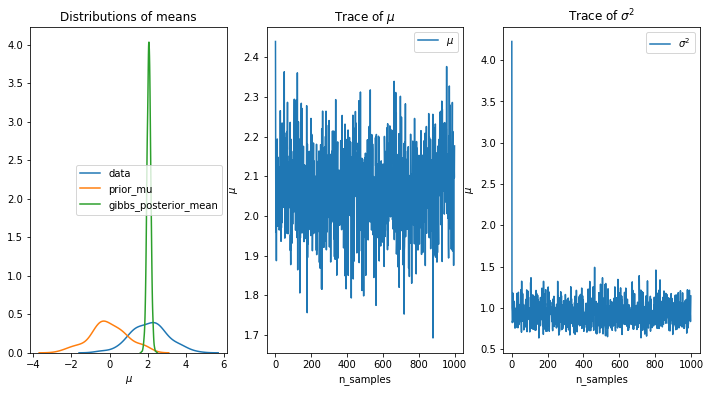

In [9]:
#prior_mu = np.random.normal(prior['mu_0'],np.sqrt(prior['sigma_0']), 10)
fig, axes = plt.subplots(1,3, figsize = (12,6))
sns.kdeplot(y,label='data',ax=axes[0])
sns.kdeplot(np.random.normal(prior_gibbs['mu_0'],np.sqrt(prior_gibbs['sig2_0']), 100), label='prior_mu',ax=axes[0])
gibbs_posterior_mean=gibbs_posterior[0]
sns.kdeplot(gibbs_posterior_mean, label='gibbs_posterior_mean', ax=axes[0])
axes[0].set_title('Distributions of means')
axes[0].set_xlabel('$\mu$')

axes[1].plot(gibbs_posterior[0],label='$\mu$')
axes[1].legend()
axes[1].set_title('Trace of $\mu$')
axes[1].set_xlabel('n_samples')
axes[1].set_ylabel('$\mu$')


axes[2].plot(gibbs_posterior[1],label='$\sigma^2$')
axes[2].legend()
axes[2].set_title('Trace of $\sigma^2$')
axes[2].set_xlabel('n_samples')
axes[2].set_ylabel('$\mu$')
fig.savefig('gibbs_result.png');

## Random Walk Metropolis Hastings Algorithm

In [10]:
def compute_candidate(y, mu, sigma, mu_0, sigma_0):
    """function to propose a candidate value
        Parameters
        ----------
        y : list[]
            data
        mu: float
            candidate mu
        sigma: float
            candidate sigma
        mu_0: float
            hyper parameter of mean
        sigma_0: float
            hyper parameter of variance
            
        Returns
        ----------
        candidate_val: float
            posterior value of the candidate
    """
    likelihood = st.norm.pdf(x=y, loc=mu, scale=np.sqrt(sigma))
    prior = st.norm.pdf(x=mu, loc=mu_0, scale=np.sqrt(sigma_0))
    candidate_val = np.log(likelihood).sum() + np.log(prior)
    return candidate_val

In [11]:
def metropolis_hastings(y, num_iter, mu_init, candidate_sd, prior):
    """function to run the main metropolis hastings algorithm
        Parameters
        ----------
        y : list[]
            data
        num_iter: int
            number of iterations of MH algorithm
        mu_init: float
            initial value of mu
        candidate_sd: float
            candidate standard deviation
        prior: dict
            dictionary containing values of prior hyper parameters
            
        Returns
        ----------
        mu_out: list[]
            trajectory of accepted values
    """
    #Initialize
    mu_out = []
    acceptance_count = 0
    #initializing mu_now to start with 0
    mu_now = mu_init
    sigma = np.var(y)
    #calculate of g(theta*) value
    candidate_prev = compute_candidate(y, mu_now, sigma, prior['mu_0'], prior['sigma_0'])
    
    # Iterate
    for i in range(0,num_iter):
    
        ## sample a candidate centered on the mean of previous mu value (mu_now)
        mu_cand = np.random.normal(mu_now, candidate_sd)

        #given this mu_cand value calculate the g(theta_{i-1}) value
        candidate_now = compute_candidate(y, mu_cand, sigma, prior['mu_0'], prior['sigma_0'])

        #next - compute the ratio
        log_alpha = candidate_now - candidate_prev
        #converting back to exp
        alpha = np.exp(log_alpha)

        #acceptance criteria
        u = np.random.uniform()
        if(u < alpha):
            mu_now = mu_cand
            acceptance_count = acceptance_count + 1 #tracking acceptance
            candidate_prev = candidate_now #also update the candidate evaluation which is our g(theta_{i-1})

        ## collecting results
        mu_out.append(mu_now)
        
        
    print("Finished running MH algorithm. The acceptance % is ",acceptance_count/num_iter * 100)
    
    return mu_out

In [12]:
y = list(np.random.normal(2,1,100))
prior_mh = {}
prior_mh['mu_0'] = 0
prior_mh['sigma_0'] = 1
num_iter = 1000
mu_init = 0
candidate_sd = 0.5
mh_posterior = metropolis_hastings(y, num_iter, mu_init, candidate_sd, prior_mh)

Finished running MH algorithm. The acceptance % is  26.1


In [13]:
def analytical_solution(y, n_samples, sigma, prior_mh, analytical_posterior_size=10000):
    """function to compute analytical solution to the problem
        Parameters
        ----------
        y : list[]
            data
        n_samples: int
            number of samples of data
        sigma: float
            standard deviation
        prior_mh: dict
            dictionary containing hyper parameter values of the prior
        analytical_posterior_size: int
            size of posterior requested
            
        Returns
        ----------
        analytical_posterior: np.array()
            posterior values of the analytical solution
    """
    mean = 1 / ((1/prior_mh['sigma_0']**2) + (n_samples/sigma**2)) * ((prior_mh['mu_0']/prior_mh['sigma_0']**2) + (np.sum(y)/sigma**2))
    variance = 1 / ((1/prior_mh['sigma_0']**2) + (n_samples/sigma**2))
    analytical_posterior = np.random.normal(mean, np.sqrt(variance), analytical_posterior_size)
    return analytical_posterior

analytical_posterior = analytical_solution(y, len(y), np.std(y), prior_mh, num_iter)

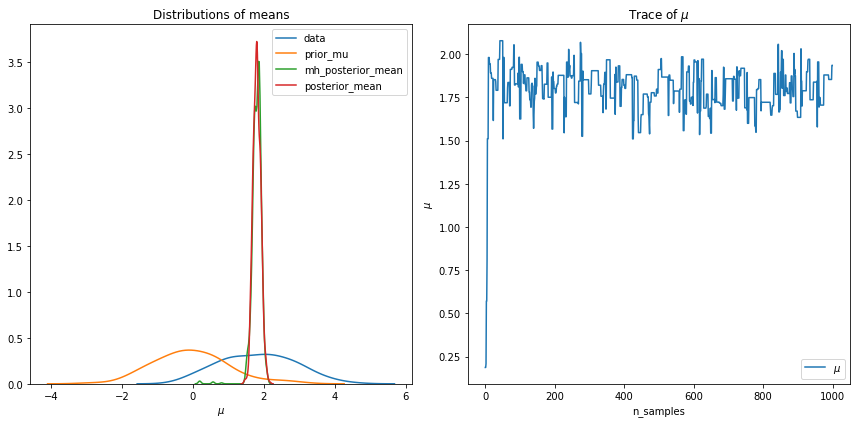

In [14]:
fig, axes = plt.subplots(1,2, figsize = (12,6))
sns.kdeplot(y,label='data',ax=axes[0])
sns.kdeplot(np.random.normal(prior_mh['mu_0'],np.sqrt(prior_mh['sigma_0']), 100), label='prior_mu',ax=axes[0])
sns.kdeplot(mh_posterior, label='mh_posterior_mean', ax=axes[0])
sns.kdeplot(analytical_posterior, label='posterior_mean', ax=axes[0])
axes[0].set_title('Distributions of means')
axes[0].set_xlabel('$\mu$')

axes[1].plot(mh_posterior,label='$\mu$')
axes[1].legend()
axes[1].set_title('Trace of $\mu$')
axes[1].set_xlabel('n_samples')
axes[1].set_ylabel('$\mu$')

fig.tight_layout()
fig.savefig('mh_result.png');

## Variational Inference

In [15]:
import torch
from torch.distributions import Normal, Gamma

import numpy as np
from tqdm import trange

# Set default type to float64 (instead of float32)
torch.set_default_dtype(torch.float64)

In [16]:
# Model parameter
class ModelParam():
    """Initialization of the ModelParams
        Parameters
        ----------
        size : int
            number of parameters we are trying to estimate
        m: torch.Tensor
            means of the parameters we are trying to estimate
        log_s: torch.Tensor
            log standard deviations of the parameters we are trying to estimate
    """
    def __init__(self, size, m=None, log_s=None):
        if m is None:
            # Set the mean for the unconstrained variational distribution.
            m = torch.randn(size)

        if log_s is None:
            #assuming the the variational standard deviation is in log_scale, remember omega = log(sigma)
            log_sigma = torch.randn(size)

        # Variational parameters 
        self.vp = torch.stack([m, log_sigma])
        self.vp.requires_grad = True

        # Dimension of the variational parameters
        self.size = size

    def dist(self):
        # Unconstrained variational distribution - we use gaussian and exponentiate
        # standard deviation since omega = log(sigma) and zeta or s_inv_eta's hyper parameters are (mu, sigma).
        return torch.distributions.Normal(self.vp[0], self.vp[1].exp())

    def rsample(self, n=torch.Size([])):
        # This is a way of sampling from the normal distribution with certain params. We use rsample 
        # since sample is just rsample with torch.no_grad(): 
        # check https://github.com/cornellius-gp/gpytorch/issues/764 for more information
        return self.dist().rsample(n)

    def log_q(self, real):
        # log variational density of parameter, evaluated on unconstrained space.
        return self.dist().log_prob(real).sum()

In [17]:
def log_prior_plus_det_Jacobian(s_inv_eta):
    """function to calculate log prior plus determinant of the jacobian
        Parameters
        ----------
        s_inv_eta : dict
            sample of the variational distribution - it's reparameterized from standard normal
            
        Returns
        ----------
        (lp_b + det_J)[0]: torch.Tensor
            sum of log prior and determinant of the jacobian
    """
    # log prior for mu, evaluated at sampled values for mu
    lp_b = Normal(0, 1).log_prob(s_inv_eta['mu']).sum()

    # log prior sig + log jacobian
    det_J = s_inv_eta['mu']

    return (lp_b + det_J)[0]

def loglikelihood(y, t_inv_s_inv_eta, full_data_size):
    """function to calculate the log likelihood of the data
        Parameters
        ----------
        y: torch.FloatTensor()
            data
        t_inv_s_inv_eta : dict
            transformation of the sampled value from the variational distribution
        full_data_size: int
            size of the data used
            
        Returns
        ----------
        Normal(mu, y.std()).log_prob(y).mean(0) * full_data_size: torch.Tensor
            log likelihood of the data
    """
    mu = t_inv_s_inv_eta['mu']
    return Normal(mu, y.std()).log_prob(y).mean(0) * full_data_size

def entropy_q(model_params, s_inv_eta):
    """function to calculate the entropy of the variational distribution
        Parameters
        ----------
        model_params: dict
            dictionary of the model parameters
        s_inv_eta : dict
            sample from the variational distribution
            
        Returns
        ----------
        out: torch.Tensor
            entropy of the variational distribution
    """
    out = 0.0
    for key in model_params:
        out += model_params[key].log_q(s_inv_eta[key])
    return out

def elbo(y, model_params, full_data_size):
    """function to calculate elbo
        Parameters
        ----------
        y: torch.FloatTensor()
            dictionary of the model parameters
        model_params : dict
            parameters of the model
        full_data_size: int
            size of the dataset
            
        Returns
        ----------
        out: torch.Tensor
            elbo value
    """
    s_inv_eta = {}
    for key in model_params:
        s_inv_eta[key] = model_params[key].rsample()
    
    # since s_inv_eta is assumed to be normal distribution and has infinite support
    # s_inv_eta and t_inv_s_inv_eta both lie in the unconstrained space and s_inv_eta doesn't have to exponentiated
    # to give t_inv_s_inv_eta
    t_inv_s_inv_eta = {'mu': s_inv_eta['mu']}

    out = loglikelihood(y, t_inv_s_inv_eta, full_data_size)
    out += log_prior_plus_det_Jacobian(s_inv_eta) 
    out -= entropy_q(model_params, s_inv_eta)

    return out

Text(0, 0.5, 'y')

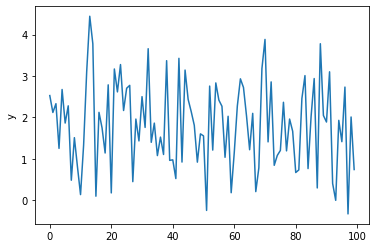

In [18]:
# set random number generator seeds for reproducibility
y = torch.FloatTensor(y)
torch.manual_seed(1)
np.random.seed(0)

# Generate data
N = y.shape[0]
#y = torch.stack([torch.randn(N)], -1)
y = torch.FloatTensor(y).reshape(y.shape[0],1)
k = y.shape[1]

# Plot data
plt.plot(y)
plt.ylabel("y")
plt.show()

In [19]:
model_params = {'mu': ModelParam(size=k)}
optimizer = torch.optim.Adam([model_params[key].vp for key in model_params], lr=.1)
elbo_hist = []

max_iter = 1000
minibatch_size = 50
torch.manual_seed(1)

iters = trange(max_iter, mininterval=1)

# Stochastic gradient descent - taking in proportion of the dataset to estimate the parameters 
for t in iters:
    sample_with_replacement = minibatch_size > N
    idx = np.random.choice(N, minibatch_size, replace=sample_with_replacement)
    #we reverse the sign since all optimizers in pytorch are minimizers
    loss = -elbo(y[idx], model_params, full_data_size=N) / N
    elbo_hist.append(-loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print progress bar
    iters.set_description('ELBO: {}'.format(elbo_hist[-1]), refresh=False)

ELBO: -1.5439858722627016: 100%|██████████| 1000/1000 [00:00<00:00, 1236.28it/s]


Text(0.5, 1.0, 'complete elbo history')

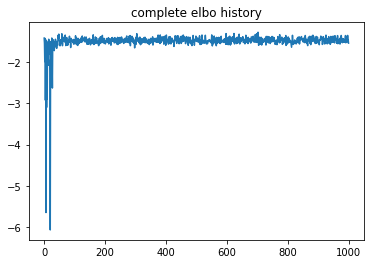

Text(0.5, 1.0, 'tail of elbo history')

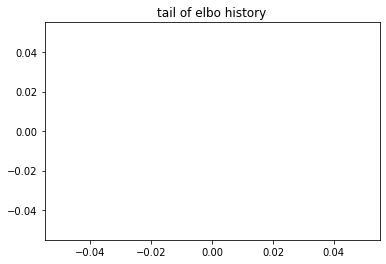

In [20]:
# Plot ELBO history
plt.plot(elbo_hist)
plt.title('complete elbo history')
plt.show()

# Plot ELBO history (after 100-th iteration)
plt.plot(elbo_hist[1000:])
plt.title('tail of elbo history')
plt.show()

In [21]:
nsamps = 1000
print('mu mean: {}'.format(model_params['mu'].vp[0].detach().numpy()))
print('mu sd: {}'.format(model_params['mu'].vp[1].exp().detach().numpy()))
print()

beta mean: [1.71853061]
beta sd: [0.10866824]

